# Vision Transformer with Keras (CPU)

In [1]:
import keras
from keras import ops
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

Hyperparameters

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 2  # For real training, use num_epochs=100. 10 is a test value
image_size = 200  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

Reading data

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '../VIT-dog-cat/data/dataset_treino_e_teste/train/'
test_dir = '../VIT-dog-cat/data/dataset_treino_e_teste/test/'

input_shape = (image_size, image_size, 3)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical')

print("Classes de treino:", train_generator.class_indices)
print("Classes de teste:", test_generator.class_indices)


num_classes = len(train_generator.class_indices)
# https://keras.io/examples/vision/image_classification_with_vision_transformer/


Found 19966 images belonging to 2 classes.
Found 4993 images belonging to 2 classes.
Classes de treino: {'Cat': 0, 'Dog': 1}
Classes de teste: {'Cat': 0, 'Dog': 1}


In [11]:
x_train = []
y_train = []
x_test = []
y_test = []

for i in range(len(train_generator)):
    x_batch, y_batch = train_generator[i]
    x_train.append(x_batch)
    y_train.append(y_batch)

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    x_test.append(x_batch)
    y_test.append(y_batch)

x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

print(f"Shape x_train {x_train.shape}")
print(f"Shape y_train {y_train.shape}")
print(f"Shape x_test {x_test.shape}")
print(f"Shape y_test {y_test.shape}")

Shape x_train (19966, 200, 200, 3)
Shape y_train (19966, 2)
Shape x_test (4993, 200, 200, 3)
Shape y_test (4993, 2)


Data augmentation

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)
data_augmentation

<Sequential name=data_augmentation, built=False>

MLP (Multilayer Perceptron)

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Patch creation

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Let's display patches for a sample image

Image size: 200 X 200
Patch size: 16 X 16
Patches per image: 144
Elements per patch: 768


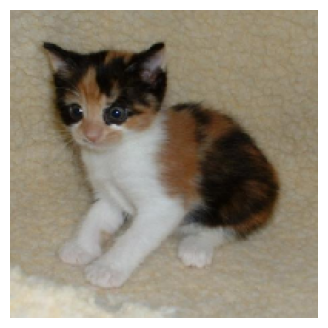

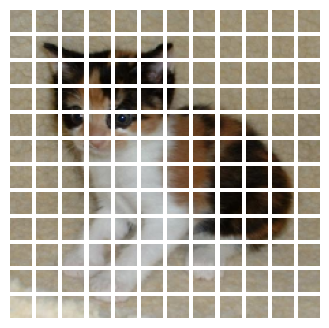

In [16]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow((image * 255).astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img * 255).astype("uint8"))
    plt.axis("off")

Patch encoding layer

In [7]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

Build VIT Model

In [8]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    # augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    # logits = layers.Dense(num_classes)(features)
    
    # Classify outputs.
    logits = layers.Dense(2, activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Run model

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5207 - loss: 4.5524 - val_accuracy: 0.5250 - val_loss: 2.1186
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.3988 - loss: 3.2742

d:\AREA_DE_TRABALHO\Faculdade_7_Periodo\TCC1\VIT-dog-cat\env\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4010 - loss: 3.2359 - val_accuracy: 0.5000 - val_loss: 0.9022
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - accuracy: 0.5008 - loss: 2.1697
Test accuracy: 50.18%


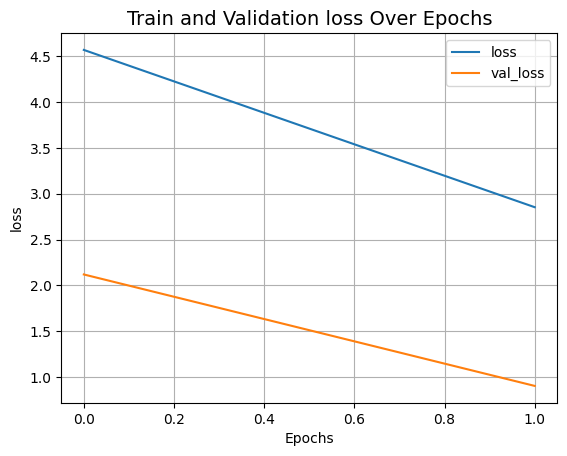

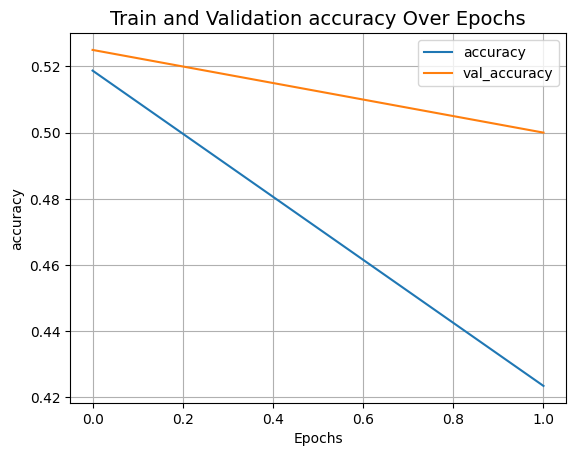

In [11]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
      ],
    )


    checkpoint_filepath = "./models/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    
    history = model.fit(
        train_generator,
        # steps_per_epoch=len(train_generator),
        steps_per_epoch=10,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=test_generator,
        validation_steps=10,
        # validation_steps=len(test_generator),
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    
    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(test_generator)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

---

# Validação

In [24]:
modelo = create_vit_classifier()
check_point_weights = "./models/checkpoint.GPU.weights.h5"
modelo.load_weights(check_point_weights)

In [25]:
path_cat = "./data/dataset_treino_e_teste/validation/Cat/"
path_dog = "./data/dataset_treino_e_teste/validation/Dog/"

### Validando imagens de Gato

In [26]:
import os
from PIL import Image
import math

./data/dataset_treino_e_teste/validation/Cat/0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Porcentagem para Gato 1%
Porcentagem para Cachorro 99%


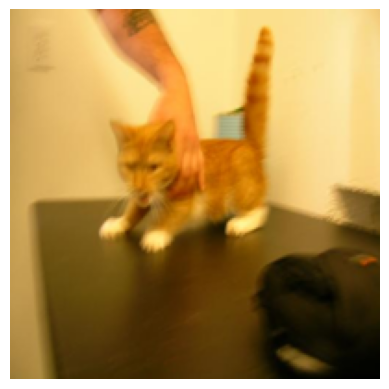

./data/dataset_treino_e_teste/validation/Cat/10.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Porcentagem para Gato 0%
Porcentagem para Cachorro 99%


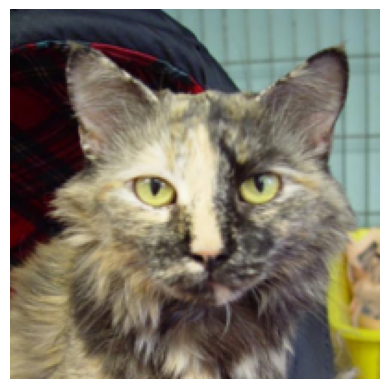

./data/dataset_treino_e_teste/validation/Cat/100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Porcentagem para Gato 0%
Porcentagem para Cachorro 99%


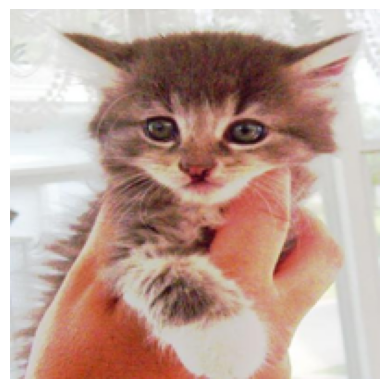

./data/dataset_treino_e_teste/validation/Cat/1000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Porcentagem para Gato 0%
Porcentagem para Cachorro 99%


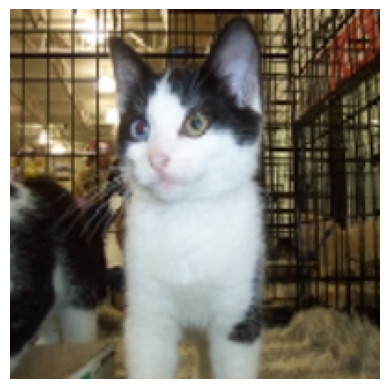

./data/dataset_treino_e_teste/validation/Cat/10000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Porcentagem para Gato 1%
Porcentagem para Cachorro 99%


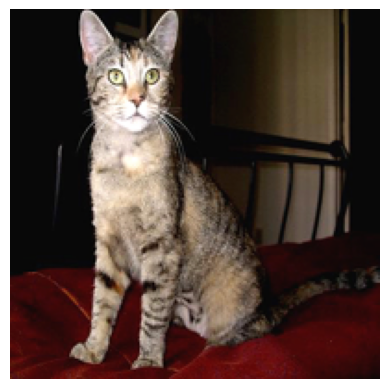

./data/dataset_treino_e_teste/validation/Dog/0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Porcentagem para Gato 0%
Porcentagem para Cachorro 99%


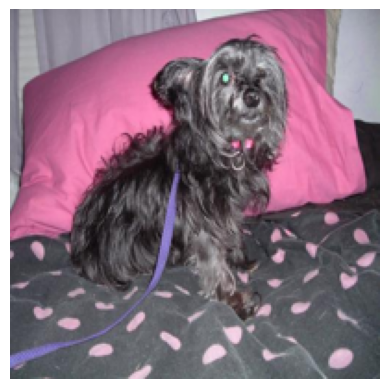

./data/dataset_treino_e_teste/validation/Dog/1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Porcentagem para Gato 0%
Porcentagem para Cachorro 99%


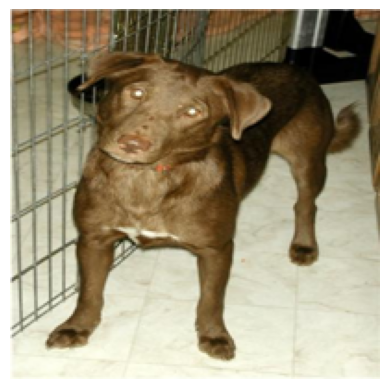

./data/dataset_treino_e_teste/validation/Dog/10.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Porcentagem para Gato 0%
Porcentagem para Cachorro 99%


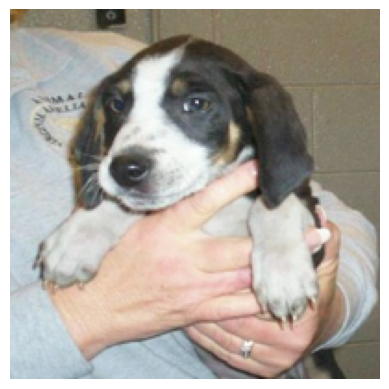

./data/dataset_treino_e_teste/validation/Dog/100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Porcentagem para Gato 0%
Porcentagem para Cachorro 99%


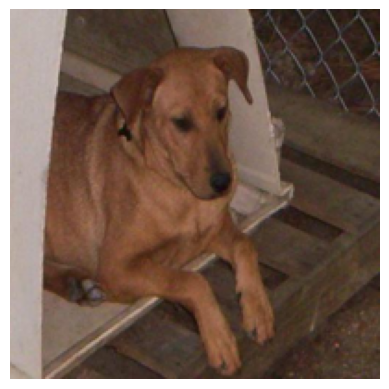

./data/dataset_treino_e_teste/validation/Dog/1000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Porcentagem para Gato 0%
Porcentagem para Cachorro 99%


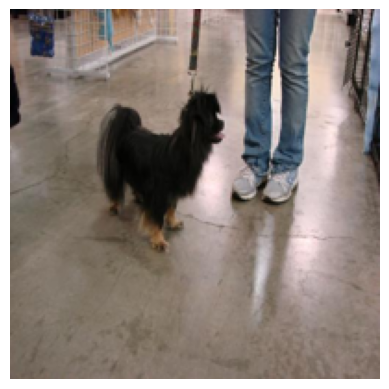

In [27]:
dataset_classifier = {"Cat" : 0, "Dog": 1}

def previsoes(path_final):

  arquivos = os.listdir(path_final)
  imagens = [arquivo for arquivo in arquivos if arquivo.endswith(('.jpg', '.jpeg'))]

  for each_img in imagens:
    path_img = os.path.join(path_final, each_img)
    try:
      print(path_img)
      img = Image.open(path_img)
      imagem_redimensionada = img.resize((image_size, image_size))
      
      img_numpy = np.array(imagem_redimensionada)

      img_numpy = np.expand_dims(img_numpy, axis=0)

      prev = modelo.predict(img_numpy)
      
      # Tratando previsao
      porc_gato = prev[0,0]
      porc_cachorro = prev[0,1]

      print(f"Porcentagem para Gato {(math.floor(porc_gato * 100))}%")      
      print(f"Porcentagem para Cachorro {(math.floor(porc_cachorro * 100))}%")      
      plt.imshow(imagem_redimensionada)
      plt.axis("off")
      plt.show()
      
    except Exception as e:
        print(f"Erro ao carregar a imagem {path_img}: {e}")
        
previsoes(path_cat)
previsoes(path_dog)